In [5]:
import numpy as np
import pandas as pd
import os
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=8)
INDEX_COLS = ['CHROM','POS','REF','ALT']

class GnomAD_df:
        
        
    
    def __init__(self,path, peak_file=None, remove_unkown=True, remove_phased_gt=True, only_peak_variants=True):
        """
        This class warps the result of gnomAD and interval  mATAC/hATAC analysis.
        path - path to the parquet dataframe file 
        peak_file - bed file which contains the following columns - CHROM,FROM,TO,INTERVAL_ID, ~BUT w/o header~
        remove_unknown - removed unkwon genotypes (e.g "./.")' 
        remove_phased_gt - "replaced phased genotype (e.g "0|1" -> "0/1")"
        only_peak_variants - removing variants outside of peak interval
        
        """
        self.__original_df = self.__open_table(path)
        self.__filter_samples = []
        self.__filters_description = []
        self.__filter_functions = []
        self.__cur_df = self.__original_df.copy()
        self.__applied_filter_index = 0
        self.f_phasing = False
        if remove_phased_gt:
            self.remove_phasing()
        if only_peak_variants:
            self.remove_non_peak_variants()
        if remove_unkown:
            self.remove_unkown()

        self.__samples = [i.split(':')[0] for i in self.__original_df.columns if i.endswith('GT')]
        if peak_file != None:
            self.__peak_df = self.__get_peak_df(peak_file)
    
    
    def __get_peak_df(self, path):
        peak_df = pd.read_csv(path, sep='\t', header=None)
        peak_df.columns = ['CHROM', 'FROM','TO', 'INTERVAL_ID']
        return peak_df
    
    def load_peak_file(peak_file_path):
        """
        loads a peak file into the object
        """
        self.__peak_df = self.__get_peak_df(peak_file)
    
    def get_peak_df(self):
        """
        returns the intervals dataframe 
        """
        return self.__peak_df
    
    def __open_table(self, path):
        if path.endswith('prq'):
            df = pd.read_parquet(path) #self.__concat_parquet_files(path)
        if path.endswith('csv'):
            df = pd.read_csv(path)
        if path.endswith('tsv'):
            df = pd.read_csv(path, sep='\t')
            
        df.replace("",np.nan, inplace=True)
        display(df.head())
        return df #.sort_values(INDEX_COLS)
    
    def add_source(self,path):
        df = self.__open_table(path)
        df.columns = [col.split(']')[1] for col in df.columns]
        df = df.set_index(INDEX_COLS)
        return df, self.__original_df
        # self.__original_df = pd.concat([self.__original_df, df], axis=1).sort_values(INDEX_COLS)
        # self.__applied_filter_index = 0
        # self.f_phasing = False
        
        

    def __remove_non_peak_variants(self):
        nrow_b = self.__cur_df.shape[0]
        self.__cur_df = self.__cur_df.replace('.', np.nan)
        self.__cur_df = self.__cur_df[~self.__cur_df.INTERVAL_ID.isna()]
        nrow_a = self.__cur_df.shape[0]
        print(f"dropped {nrow_b - nrow_a} variants")

    def remove_non_peak_variants(self):
        """
        remove variants if they are not in a peak
        """
        decs="removing variants outside of peak interval"
        
        if self.__check_if_filter_exists(decs):
            self.__filters_description.append("removing variants outside of peak interval")
            self.__filter_functions.append(self.__remove_non_peak_variants)
        return self

    def __remove_unknow(self):
        n_b = self.__cur_df.isna().sum().sum()
        self.__cur_df = self.__cur_df.replace('./.', np.nan).replace('.|.', np.nan)
        n_a = self.__cur_df.isna().sum().sum()
        print(f"dropped {n_b - n_a} variants")

    def remove_unkown(self):
        """
        removed unkwon genotypes (e.g "./.")
        """
        decs='removed unkwon genotypes (e.g \"./.\")'
        
        if self.__check_if_filter_exists(decs):
            self.__filters_description.append('removed unkwon genotypes (e.g \"./.\")')
            self.__filter_functions.append(self.__remove_unknow)
        return self

    def remove_phasing(self):
        """
        "replaced phased genotype (e.g "0|1" -> "0/1")"
        """
        desc = "replaced phased genotype (e.g \"0|1\" -> \"0/1\")"
        if self.__check_if_filter_exists(desc):
            self.__filters_description.append(desc)
            self.__filter_functions.append(self.__remove_phasing)
        return self

    def __remove_phasing(self):

        """
        replace all "X|X" into "X/X"
        """
        if self.f_phasing: return
        for col in [i for i in self.__cur_df.columns if i.endswith('GT')]:
            for val in self.__cur_df[col].unique():
                if val == np.nan: continue
                if '|' in str(val):
                    self.__cur_df = self.__cur_df.replace(val, "%s/%s" % tuple(val.split('|')))
        self.f_phasing = True
    
    
    def __check_if_filter_exists(self,description):
        """
        Indicate if a filter already applied on the DF by checking if the description exist in the list.
        Return True if filter was not applied
        """
        if description in self.__filters_description:
            print(f"{description.split('(')[0]} already applied")
            return False
        return True
        
        
    
    def filter_DP(self, dp_t:float):
        """
        Fiter the variants (replace the GT with NaN) according to a given threshold (dp_t)
        """
        desc = f"Removing variants with reading depth {dp_t} or below"
        if self.__check_if_filter_exists(desc):
            self.__filters_description.append(desc)
            self.__filter_functions.append(lambda: self.__filter_dp(dp_t))
        return self

    def __filter_dp(self, dp_t:float):
        n_b = self.__cur_df.isna().sum().sum()
        for sample in self.__samples:
            self.__cur_df.loc[self.__cur_df[sample + ':DP'] <= dp_t, sample + ':GT'] = np.nan
        n_a = self.__cur_df.isna().sum().sum()
        print(f"dropped {n_b - n_a} variants")

    def ___filter_AF_remove_unknown(self, af_t:float):
        nrow_b = self.__cur_df.shape[0]
        self.__cur_df = self.__cur_df[(self.__cur_df.AF_popmax <= af_t) | (self.__cur_df.AF_popmax.isna())]
        nrow_a = self.__cur_df.shape[0]
        print(f"dropped {nrow_b - nrow_a} variants")

    def ___filter_AF(self,af_t:float):
        nrow_b = self.__cur_df.shape[0]
        self.__cur_df = self.__cur_df[(self.__cur_df.AF_popmax <= af_t)]
        nrow_a = self.__cur_df.shape[0]
        print(f"dropped {nrow_b - nrow_a} variants")

    def filter_AF(self, af_t: float,remove_unkwon=False):
        """
        Filters the variants of gnomAD's allele frequency (AF) below a given threshold.
        If remove_unkown is True, remove variants with no record on gnomAD
        """
        description = f"Removing variants with allele frequency above {af_t}"
        description += " and variants with no record on gnomAD" if remove_unkwon else ""
        if self.__check_if_filter_exists(description):
            self.__filters_description.append(description)
            if not remove_unkwon:
                self.__filter_functions.append(lambda :self.___filter_AF_remove_unknown(af_t))
            else:
                self.__filter_functions.append(lambda :self.___filter_AF(af_t))
        return self

    def filter_samples(self,sample_list, appened=True):
        """
        Filter the variants dataframe to a given set of samples.
        If appened is False, remove all previous given samples of filteration

        """
        if appened:
            self.__filter_samples += sample_list
        else:
            self.__filter_samples = sample_list
        return self

    
    def __drop_variant_rows(self):
        nrow_b =  self.__cur_df.shape[0]
        for index, col in enumerate(self.__cur_df.columns):
            if ':' in col:
                break
        self.__cur_df = self.__cur_df[~self.__cur_df.iloc[:,index:].isna().all(axis=1)]
        nrow_a =  self.__cur_df.shape[0]
        print(f"dropped {nrow_b - nrow_a} variants")
    
    def __sample_filter(self):
        to_drop = [col for col in self.__cur_df.columns if col.split(':')[0] in self.__filter_samples]
        self.__cur_df = self.__cur_df.drop(columns=to_drop)
        self.__drop_variant_rows()
        

        
    def print_filters(self):
        """
        prints the filters applied on the variant df
        """
        for f in range(len(self.__filters_description)):
            print(f"{f}. {self.__filters_description[f]}")

    def remove_filter(self, i):
        """
        remove the i'th filter from the table 
        To know the filters index, use "print_filter"
        """
        if i >= len(self.__filters_description):
            print("Filter does not exist")
            return self
        del self.__filters_description[i]
        del self.__filter_functions[i]
        if i <= self.__applied_filter_index:
            self.__cur_df = self.__original_df.copy()
            self.f_phasing = False
            self.__applied_filter_index = 0
        return self

    def reset_table(self, remove_phased_gt=True, remove_unkown=True, only_peak_variants=True):
        """
        returns the dataframe to it's initial state.
        removes all filters applied on the dataframe
        """
        self.__filter_samples = []
        self.__filters_description = []
        self.__filter_functions = []
        self.__applied_filter_index = 0
        self.__samples = [i.split(':')[0] for i in self.__original_df.columns if i.endswith('GT')]
        self.__cur_df = self.__original_df.copy()
        self.f_phasing = False
        if only_peak_variants:
            self.remove_non_peak_variants()
        if remove_phased_gt:
            self.remove_phasing()
        if remove_unkown:
            self.remove_unkown()
        return self

    def get_filters_decription(self):
        """
        returns list of filter description
        """
        return self.__filters_description
        
    def __apply_filters(self, verbos=True):
        max_index = len(self.__filters_description)

        if verbos:
            for i in range(self.__applied_filter_index):
                print(self.__filters_description[i])
        for i in range(self.__applied_filter_index, max_index):
            if verbos:
                print(self.__filters_description[i])
            self.__filter_functions[i]()
        # filter samples only if there are samples in the list
        if len(self.__filter_samples):
            if verbos:
                print("Filtering samples")
            self.__sample_filter()
        print("done")
        self.__applied_filter_index = max_index

    def __concat_parquet_files(self, folder_path):
        # List all files in the folder
        files = os.listdir(folder_path)
        print("I;m here")
        # Filter Parquet files with names matching the pattern chr[1..22,X,Y].parquet
        parquet_files = [file for file in files if  file.endswith(".prq")]

        if len(parquet_files) == 0:
            print("No Parquet files found in the folder.")
            return None

        # Read the first Parquet file to initialize the DataFrame
        df = pd.read_parquet(os.path.join(folder_path, parquet_files[0]))

        # Concatenate remaining Parquet files to the DataFrame
        for file in parquet_files[1:]:
            file_path = os.path.join(folder_path, file)
            df_chunk = pd.read_parquet(file_path)
            df = pd.concat([df, df_chunk])

        return df


    def get_table(self, verbos=True):
        """
        returns the variants df filtered by all given filters.
        Verbos = true -> prints the log of filteration
        """
        if verbos:
            print("applying filters")
        self.__apply_filters(verbos)
        if verbos:
            print('getting table')
        return self.__cur_df.copy()

    def __remove_reference(self):
        """
        removing 0/0 and 0/. or ./0 from the table (not saving the dataframe)
        """
        letters = ['0', '.']
        df = self.__cur_df.copy()
        for i in letters:
            for j in letters:
                df = df.replace(f"{i}|{j}", np.nan)
        return df

    def bool_variant_df(self, verbos=True):
        """
        returns a boolean table of samples VS variants.
        True if the variant exist in the sample.
        NOTICE- THIS APPLY REMOVE PHASING FILTER ON DF
        """
        self.__remove_phasing()
        self.__apply_filters(verbos)
        df = self.__remove_reference()
        gt = df[[i for i in df.columns if i.endswith('GT')]].replace(' ',np.nan).replace('',np.nan).notna()
        gt.columns = [i.replace(':GT','') for i in gt.columns ]
        
        return pd.concat([df[['INTERVAL_ID']],gt], axis=1)
    
    
    
    def __add_interval_info(self,df,drop_all_zero=False):
        """
        assuming df index is the interval_id
        """
        peak_df_isin = self.__peak_df[self.__peak_df.INTERVAL_ID.isin(df.index)].set_index('INTERVAL_ID')
        result = pd.concat([peak_df_isin,df], axis=1)
        if not drop_all_zero:
            peak_df_isout = self.__peak_df[~self.__peak_df.INTERVAL_ID.isin(df.index)].set_index('INTERVAL_ID')
            result = pd.concat([result, peak_df_isout])
        return result
    
    
    
    def count_interval(self, boolean=False, drop_all_zero=False, per_sample=False):
        """
        returns a dataframe with the amount of variant each  in each peak.
        if boolean = True, reaturns a df of interval vs samples with Trued if sample ahve varint in that interval
        if drop_all_zero = True, drop all interval with zero variants 
        if per_sample = True returns a dataframe with the amount of variant per sample in each peak.
        """
        df =  self.bool_variant_df().drop(columns=['AF'])
        sum_df = df.groupby('INTERVAL_ID').sum()
        sum_df = sum_df if not boolean else sum_df != 0
        if not per_sample:
            sum_df = sum_df.sum(axis=1)
        return self.__add_interval_info(sum_df,  drop_all_zero)      
    
    def count_peaks_variants(self,numeric=False):
        """
        returns data frame with the amount of people who have variants in each interval
        if numeric is True - the total number of variants there are in each peak of all samples
        """
        bool_df = self.bool_variant_df().drop(columns=['AF'])
        melt_df = bool_df.melt(id_vars=['INTERVAL_ID'])
        melt_df = melt_df[melt_df.value]
        if numeric:
            melt_df = melt_df.groupby('INTERVAL_ID')
        else:
            melt_df = melt_df.drop_duplicates().groupby('INTERVAL_ID')
        result = melt_df.value.sum().sort_values()
        if numeric:
            result = result.rename(columns={0:'n_variants'})
        return 

    
    def ___median_of_positive_columns(self, search_string):
        # Filter columns that contain the search_string
        filtered_df = df.filter(like=search_string)

        # Replace non-positive values with NaN
        positive_df = filtered_df.mask(filtered_df <= 0)

        # Calculate the median for each row
        median_values = positive_df.median(axis=1)

        return median_values
    
    def sum_peaks(self):
        """
        sum the amount of variants in each peak 
        """
        bool_df = self.bool_variant_df()
        return bool_df.groupby('INTERVAL_ID').sum()
    
    def get_samples(self):
        return [i for i in self.__samples if i not in self.__filter_samples]
    
    def add_ken_to_main(self, to_add_path, sample_name=False, header=True, ken=False):
        """
        This functions add kens tsv data to the main df
        ken - the data is kens source
        """
    
        main_df = self.__original_df.copy()
        if not sample_name:
            sample_name = to_add_path.split('/')[-1].split('.')[0]
        if sample_name in self.__samples:
            print(f"{sample_name} already exist")
            return self
        to_add = pd.read_csv(to_add_path, sep='\t', header=None if not header else 0)
        col_names = [f'{sample_name}:GT',f'{sample_name}:DP']
        columns = ['CHROM','POS', 'REF','ALT','INTERVAL_ID','AF'] + col_names
        to_add.columns = columns
        if ken:
            to_add.ALT = to_add.ALT.str.replace(',<NON_REF>','')
        to_add = to_add.replace('.',np.nan).set_index(['CHROM', 'POS', 'ALT', 'REF']).fillna(value=np.nan)
        to_add[f'{sample_name}:DP'] = to_add[f'{sample_name}:DP'].astype(float)
        to_add.AF = to_add.AF.astype(float)
        exist = to_add[to_add.index.isin(main_df.index)]
        non_exist = to_add[~to_add.index.isin(main_df.index)]
#         return main_df,exist[col_names]
        main_df = pd.concat([main_df,exist[col_names]],axis = 1)

        main_df = pd.concat([main_df, non_exist.drop(columns=col_names)])
        main_df.loc[non_exist.index,col_names] = non_exist[col_names]
        self.__original_df = main_df
        self.reset_table()
        return self


    
    
    def count_sample_variants(self,verbos=True):
        """
        Counts the amount of variant each sample have.
        """
        bool_df = self.bool_variant_df(verbos=verbos)
        bool_df[bool_df.INTERVAL_ID.notna()  & bool_df.AF_popmax.notna() ]
        result = bool_df[bool_df.INTERVAL_ID.notna() & bool_df.AF_popmax.notna()]
        return result.drop(columns=['AF_popmax','INTERVAL_ID']).sum()
    
    def save_df(self,save_format, path, original=False):
        """
        save the df in the format mentioned: csv/prq(parquet)
        """
        df = self.__original_df if original else self.get_table() 
        if save_format == 'csv':
            df.to_csv(f"{path}.{save_format}")
        elif  save_format == 'prq':
            df.to_parquet(f"{path}.{save_format}")
    
    
    def concat(gnomAD_df_list: list, reset_df=False, verbos=True):
        """
        Generate a new gnomAD_df from a list of gnomAD_df.
        The function takes the filtered DF from each object and creates a new one.
        all previous filters will not be transfered, hence- the basiv DF of the new df
        won't have the original's dfs data
        """
        df_list = []
        template = 'for samples %s the following filteres were applied:'
        for df in gnomAD_df_list:
            if verbos:
                samples = ",".join(df.get_samples())
                print(template % samples)
                for i in df.get_filters_decription():
                    print(i)
            df_list.append(df.get_table(verbos = False))
        new_df = pd.concat(df_list, axis=1)
        return GnomAD_df(new_df)
    
    

                      

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
pedg_tree= 'data/read_only/samples/sample_metadata.xlsx'
pedg_df = pd.read_excel(pedg_tree)
pedg_df.ID = pedg_df.ID.astype(str)

In [7]:
sample_file_path = 'data/pipeline_outputs/variants_with_layers/qualityDSD_variants.csv'
gnomad = GnomAD_df(sample_file_path)


,former_index,CHROM,POS,REF,ALT,FILTER,AF,AF_popmax,INTERVAL_ID,GHid,...,52037:GT,52037:DP,52037:GQ,52038:GT,52038:DP,52038:GQ,52040:GT,52040:DP,52040:GQ,__index_level_0__
0,13073,chr1,20633450,G,C,,-1.000000,-1.000000,82022_Y35_82023_XY1235_GR.PG.PS.SE730,,...,,NaN,NaN,,NaN,NaN,,NaN,NaN,620204
1,13094,chr1,20653210,C,T,PASS,0.000007,0.000015,82020_Y35,,...,,NaN,NaN,,NaN,NaN,,NaN,NaN,564508
2,13113,chr1,20696314,T,C,PASS,0.000007,0.000024,82018_XY135X2_GR.PG.PS.SE733,,...,,NaN,NaN,,NaN,NaN,,NaN,NaN,564527
3,13136,chr1,20717896,C,G,,-1.000000,-1.000000,82016_XY1235_GR.PG.PS.SE734,,...,,NaN,NaN,,NaN,NaN,,NaN,NaN,620212
4,13138,chr1,20718149,C,T,PASS,0.003897,0.006029,82016_XY1235_GR.PG.PS.SE734,,...,,NaN,NaN,,NaN,NaN,,NaN,NaN,564547


In [55]:
# gnomad.reset_table()
# gnomad.filter_samples(pedg_df[pedg_df.fam_relation != 0].ID.tolist())


In [11]:
df = gnomad.bool_variant_df()

replaced phased genotype (e.g "0|1" -> "0/1")
removing variants outside of peak interval
removed unkwon genotypes (e.g "./.")
done


In [ ]:
# prob_df = df[['INTERVAL_ID'] + df.columns[df.columns.isin(pedg_df.ID.astype(str).tolist())].tolist()]

test = df.groupby('INTERVAL_ID').apply(get_interval_stats)

AttributeError: 'DataFrame' object has no attribute 'source'

In [14]:
import numpy as np
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=8)
from bin.Gonen_func import *


def get_interval_stats(df_in, pedg_df):
    df = df_in.drop(columns='INTERVAL_ID')
    sum_per_sample = df.sum(axis=0)
    exist_per_sample = df.any(axis=0)
    sum_series = pd.Series(dtype=float)
    probands =  pedg_df[pedg_df.fam_relation == 0].ID.astype(str)
    sum_series['total n probands'] = exist_per_sample[exist_per_sample.index.isin(probands)].sum()
    sum_series['total n non-DSD'] = exist_per_sample.sum() - sum_series['total n probands']
    sum_series['total n proband variants'] = sum_per_sample[sum_per_sample.index.isin(probands)].sum()
    sum_series['total n non-DSD'] = sum_per_sample.sum() - sum_series['total n proband variants'] 
    for label in pedg_df.source.unique():
        label_id =  pedg_df[pedg_df.source == label].ID.astype(str)
        probans_id = label_id[label_id.isin(probands)]
        sum_series[f'{label} n probands'] = exist_per_sample[exist_per_sample.index.isin( probans_id)].sum()
        sum_series[f'{label} n non-DSD'] = exist_per_sample[exist_per_sample.index.isin( label_id)].sum() -  sum_series[f'{label} n probands']
        sum_series[f'{label} n proband variants'] = sum_per_sample[sum_per_sample.index.isin(probans_id)].sum()
        sum_series[f'{label} n non-DSD variants'] = sum_per_sample[sum_per_sample.index.isin(label_id)].sum() - sum_series[f'{label} n proband variants']

    return sum_series

def bool_variant_df(df):
    """
    returns a boolean table of samples VS variants.
    True if the variant exist in the sample.
    """
    gt = df[[i for i in df.columns if i.endswith('GT')]].replace(' ',np.nan).replace('',np.nan).notna()
    gt.columns = [i.replace(':GT','') for i in gt.columns ]

    return pd.concat([df[['INTERVAL_ID']],gt], axis=1)

def get_sample_numbers(pedg_df, source=None):
    df = pedg_df  if source == None else pedg_df[pedg_df.source == source]
    result = {'total': df.shape[0],'probands' :(~df.fam_relation.astype(bool)).sum()}
    return result

def create_sample_dict(pedg_df,columns):
    key_template = '%s\n (n=%s n_prob=%s)'
    
    numbers = get_sample_numbers(pedg_df)
    sample_dict = {key_template % ('total', numbers['total'], numbers['probands']) : [i for i in columns if 'total' in i]} 
    for sample in  pedg_df.source.unique().tolist():
        numbers = get_sample_numbers(pedg_df, sample)
        sample_dict.update({key_template % (sample, numbers['total'], numbers['probands']) : [i for i in columns if sample in i]})
    return sample_dict

def save_to_excel(result, pedg_df, output_file, upload_path):
    interval_dict = {'Peak' : ['CHROM','from','to','length'],
                    'Gene data': ['DSDgenes_1.5mb','geneHancer','GHid','GH_is_elite','GH_type']}
    interval_dict.update(create_sample_dict(pedg_df, result.columns))
    create_excel(result, interval_dict, output_file, upload_path=upload_path)


def get_info_table(df):
    relevant_coulmns = ['CHROM','from', 'to', 'length', 'DSDgenes_1.5mb','geneHancer', 'GHid', 'GH_is_elite', 'GH_type']
    df = df[~df.INTERVAL_ID.duplicated()].set_index('INTERVAL_ID')
    return df[relevant_coulmns]

    

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [15]:


def main(sample_file_path, pedg_path, output_file, upload_path=None):
    print( "reading files")
    df = pd.read_csv(sample_file_path)
    pedg_df= pd.read_excel(pedg_path)
    print("analysing peaks")
    peak_df = bool_variant_df(df)
    peak_df = peak_df.groupby('INTERVAL_ID').parallel_apply(lambda x: get_interval_stats(x,pedg_df))
    
    result  = pd.concat([get_info_table(df),peak_df],axis=1)
    print("saving")
    save_to_excel(result, pedg_df, output_file, upload_path)

    
    
sample_file_path = 'data/pipeline_outputs/variants_with_layers/qualityDSD_variants.csv'
pedg_path= 'data/read_only/samples/sample_metadata.xlsx'
cur_upload='Nitzan_Gonen_lab/Joint_projects/WGS_on_DSD/Ido/hot_peaks'
cur_save="~/bcftools_prog/DSD_project/data/hot_peaks_fixed" 
main(sample_file_path, pedg_path,cur_save,cur_upload)

reading files
analysing peaks


saving


Uploading 695 KiB/695 KiB


Command executed successfully.


In [76]:
df = gnomad.get_table()
df = df[~df.INTERVAL_ID.duplicated()].set_index('INTERVAL_ID')
df = df[[i for i in df.columns if ":" not in i]]
df.columns


applying filters
replaced phased genotype (e.g "0|1" -> "0/1")
removing variants outside of peak interval
removed unkwon genotypes (e.g "./.")
done
getting table


In [108]:
import Gonen_func

In [101]:
{f'total\n (n={get_sample_numbers(pedg_df)["total"]} n_prob={get_sample_numbers(pedg_df)["probands"]} )': [i for i in result.columns if 'total' in i]},f'sinclair\n (n={get_sample_numbers(pedg_df, "sinclair")["total"]} n_prob={get_sample_numbers(pedg_df, "sinclair")["probands"]} )': [i for i in result.columns if 'sinclair' in i]}

SyntaxError: invalid syntax (1154735733.py, line 1)

In [130]:
# import importlib

# Reload a package or module named 'your_module_name'
importlib.reload(Gonen_func)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


<module 'Gonen_func' from '/cs/labs/michall/toozig/jupyter_notebooks/DSD/bcftools_prog/gnomAD_df_class/code/Gonen_func.py'>

{'total\n (n=65 n_prob=47)': ['total n probands',
  'total n samples',
  'total n proband variants',
  'total n variants'],
 'sinclair\n (n=24 n_prob=9)': ['sinclair n samples',
  'sinclair n probands',
  'sinclair n variants',
  'sinclair n proband variants'],
 'ken\n (n=36 n_prob=35)': ['ken n samples',
  'ken n probands',
  'ken n variants',
  'ken n proband variants'],
 'zangen\n (n=5 n_prob=3)': ['zangen n samples',
  'zangen n probands',
  'zangen n variants',
  'zangen n proband variants']}

In [141]:


# interval_dict

In [68]:
df = df[df.quality == 'PASS']
df = df[df['DSDgenes_1.5mb'] != '']
# df.columns.tolist()
# df.drop(columns='__index_level_0__').to_parquet( '/cs/usr/toozig/bcftools_prog/DSD_project/data/process_variant_by_region/only_quality.prq')

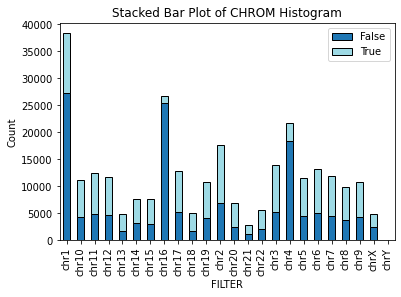

In [94]:
import matplotlib.pyplot as plt

def stacked_bar_plot(df, group_series):
    # Group the DataFrame by the provided Series
    grouped_df = df.groupby(group_series)

    # Initialize an empty dictionary to store the histogram data for each group
    hist_data = {}

    # Compute the histogram for each group and store it in the dictionary
    for group, group_data in grouped_df:
        hist_data[group] = group_data['CHROM'].value_counts()

    # Convert the histogram data into a DataFrame
    stacked_df = pd.DataFrame(hist_data).fillna(0)

    # Create the stacked bar plot
    stacked_df.plot(kind='bar', stacked=True, colormap='tab20', edgecolor='black')

    # Add labels and title
    plt.xlabel(group_series.name)
    plt.ylabel('Count')
    plt.title('Stacked Bar Plot of CHROM Histogram')
    
    # Show the plot
    plt.show()
    
stacked_bar_plot(dff,in_gnomad )

FILTER
False    145552
True     133839
dtype: int64

145552


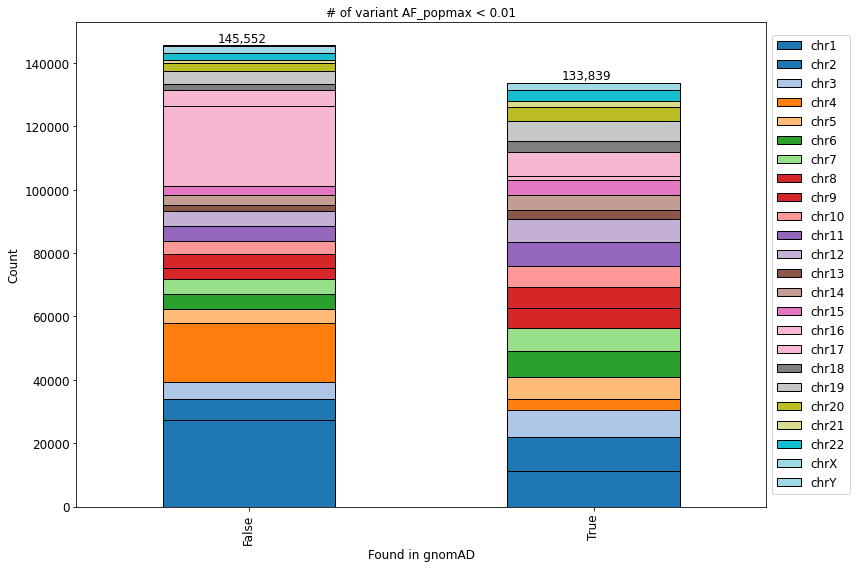

In [157]:





def group_bar_plot(df, group_series, figsize=(12, 8), fontsize=12, cmap='tab20'):
    # Define a custom sorting order for the CHROM column (chromosome order)
    chrom_order = ['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY']

    # Group the DataFrame by the provided Series and calculate the total count of "CHROM" for each group
    grouped_df = df.groupby(group_series)['CHROM'].value_counts().unstack(fill_value=0)

    # Reorder the columns in the DataFrame based on the custom sorting order
    grouped_df = grouped_df.reindex(columns=chrom_order, fill_value=0)

    # Create the bar plot with stacked bars
    fig, ax = plt.subplots(figsize=figsize)
    grouped_df.plot(kind='bar', stacked=True, cmap=cmap, edgecolor='black', ax=ax)

    # Add labels and title with larger text size
    ax.set_xlabel(group_series.name, fontsize=fontsize)
    ax.set_ylabel('Count', fontsize=fontsize)
    ax.set_title('# of variant AF_popmax < 0.01', fontsize=fontsize)

    # Enlarge the legend text size and move it to the right side
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=fontsize)

    # Set larger tick label font size
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    # Add annotations for each bar to display the total count on top of it
    sum_df = grouped_df.sum(axis=1)
    display(sum_df)
    print(sum_df[0])
    true_sum = sum_df[1]
    false_sum = sum_df[0]
    width = 0.8  # Width of each bar
    ax.annotate(f'{true_sum:,}', (1 - width/40, true_sum + 0.5), ha='center', va='bottom', fontsize=fontsize)
    ax.annotate(f'{false_sum:,}', (0 - width/40, false_sum+ 0.5), ha='center', va='bottom', fontsize=fontsize)
    ax.set_xlabel("Found in gnomAD")
    # Show the plot
    plt.tight_layout()
    plt.show()
    
group_bar_plot(dff,in_gnomad)

In [119]:
dff[]

[[0.7372549  0.74117647 0.13333333 1.        ]
 [0.54901961 0.3372549  0.29411765 1.        ]
 [0.89019608 0.46666667 0.76078431 1.        ]
 [0.68235294 0.78039216 0.90980392 1.        ]
 [0.49803922 0.49803922 0.49803922 1.        ]
 [0.78039216 0.78039216 0.78039216 1.        ]
 [0.83921569 0.15294118 0.15686275 1.        ]
 [0.85882353 0.85882353 0.55294118 1.        ]
 [0.58039216 0.40392157 0.74117647 1.        ]
 [0.17254902 0.62745098 0.17254902 1.        ]
 [1.         0.59607843 0.58823529 1.        ]
 [0.61960784 0.85490196 0.89803922 1.        ]
 [0.09019608 0.74509804 0.81176471 1.        ]
 [1.         0.73333333 0.47058824 1.        ]
 [0.77254902 0.69019608 0.83529412 1.        ]
 [1.         0.49803922 0.05490196 1.        ]
 [0.59607843 0.8745098  0.54117647 1.        ]
 [0.12156863 0.46666667 0.70588235 1.        ]
 [0.96862745 0.71372549 0.82352941 1.        ]
 [0.76862745 0.61176471 0.58039216 1.        ]]
[[1.         0.49803922 0.05490196 1.        ]
 [0.61960784